In [3]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dnnlib
import pickle
import matplotlib.pyplot as plt
from Utils.basic_utils import *
from Utils.cfg_utils import *
from Utils.cpc_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device = torch.device('cuda')

##  In previous notebooks, we've studied the working mechanisms of linear diffusion models. We now explore how these findings extend to real-world nonlinear diffusion models. First, we will demonstrate that diffusion models transition from a linear regime to a nonlinear regime as the noise level decreases. In the linear regime, the nonlinear diffusion model can be well approximated by the linear diffusion model.

100%|██████████| 10/10 [00:00<00:00, 24.33step/s]


First row: EDM Sampling Trajectory
Second row: Linear Sampling Trajectory
Image 1


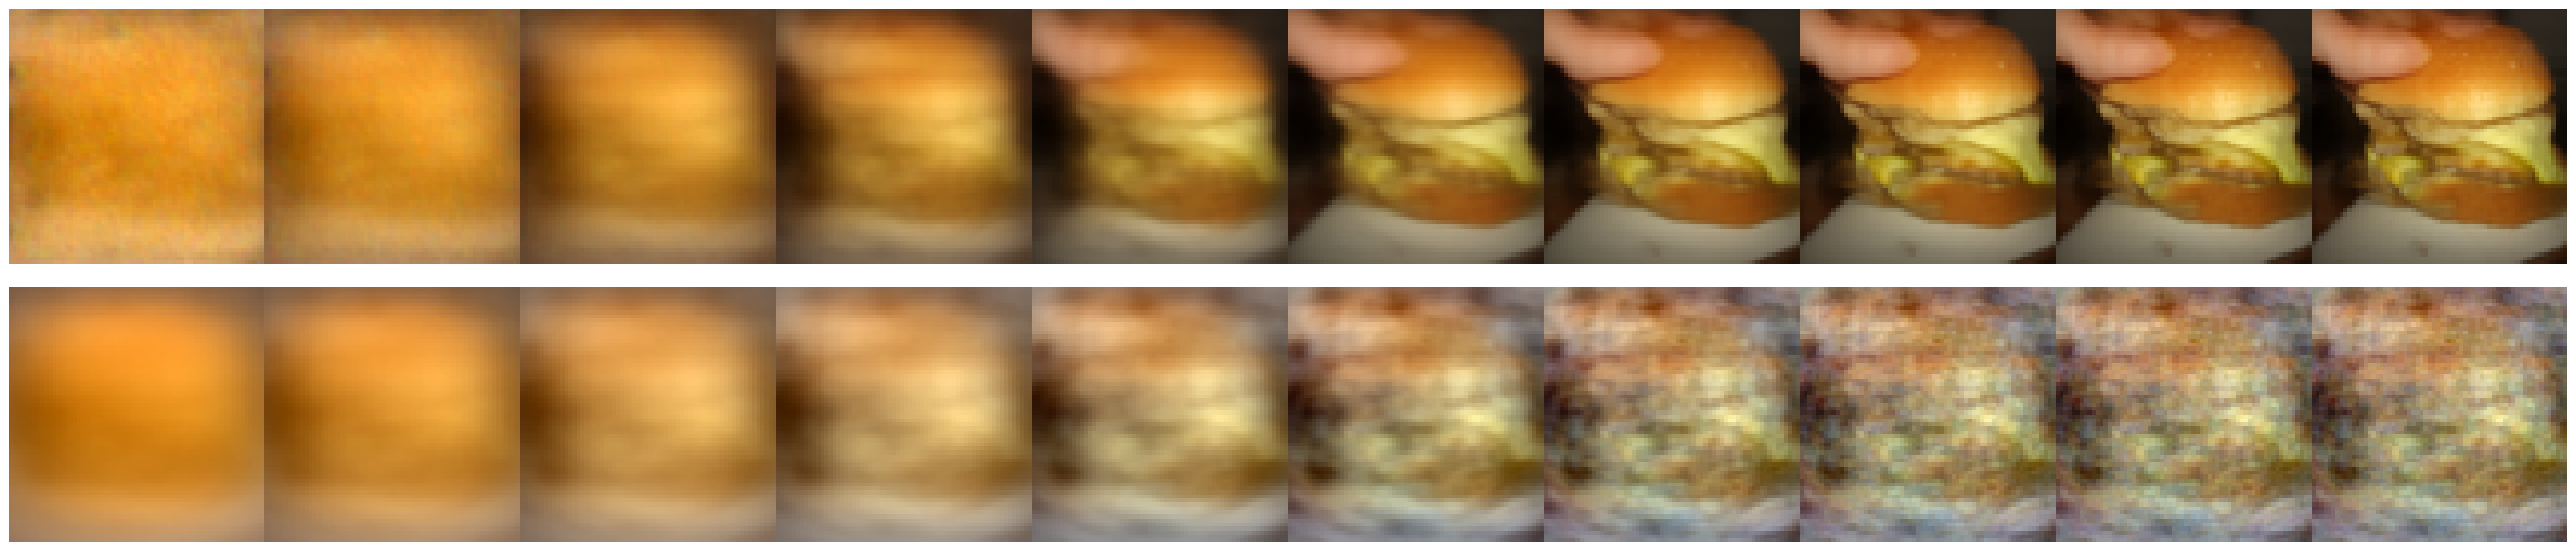

Image 2


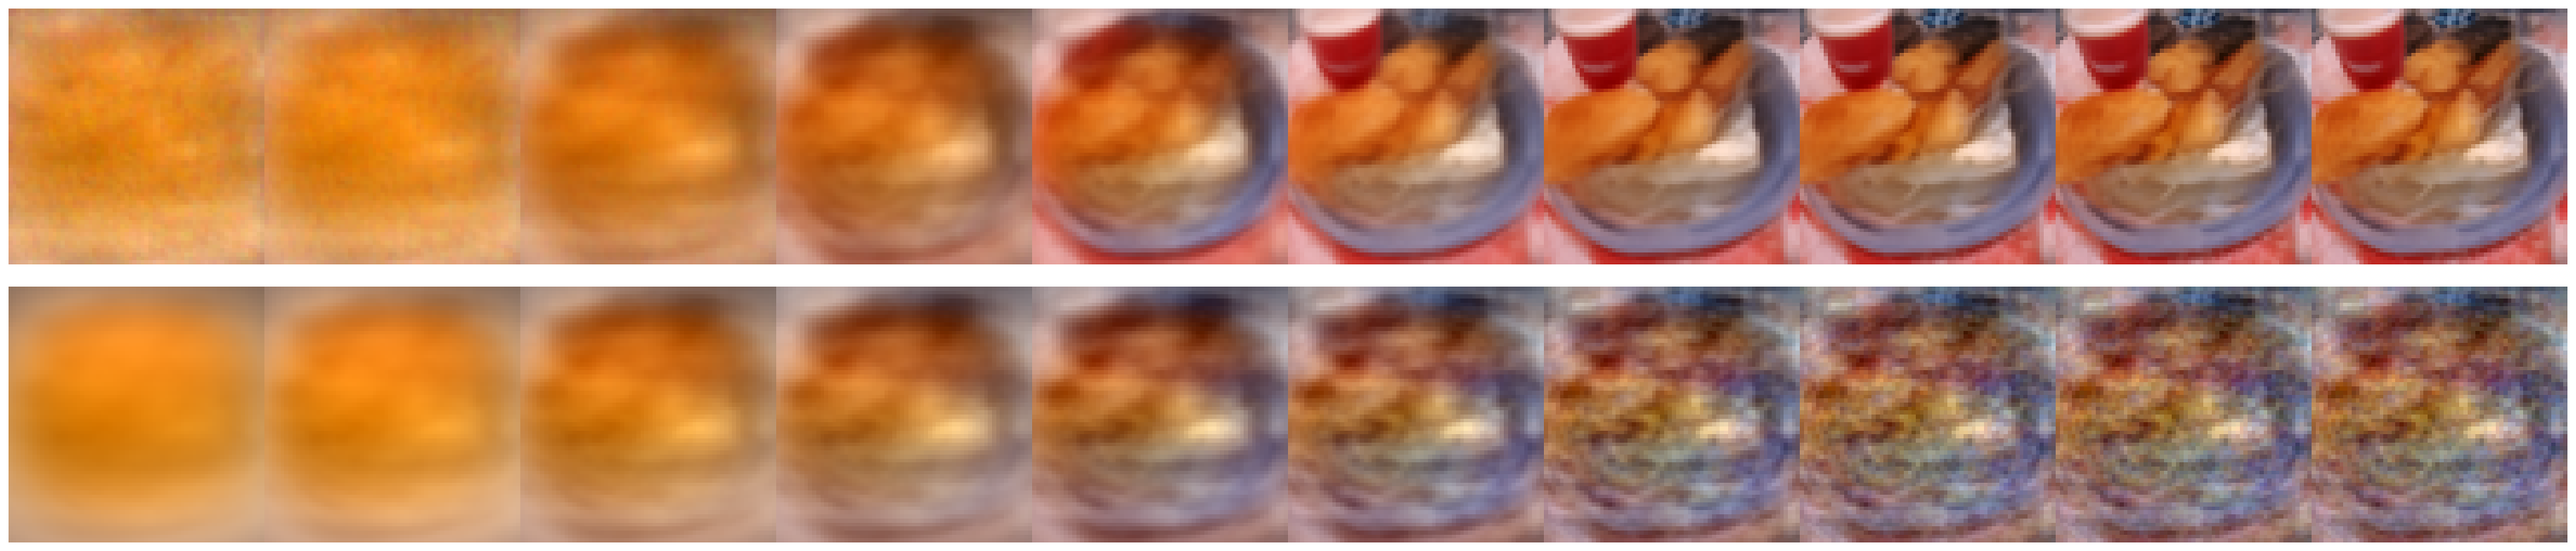

Image 3


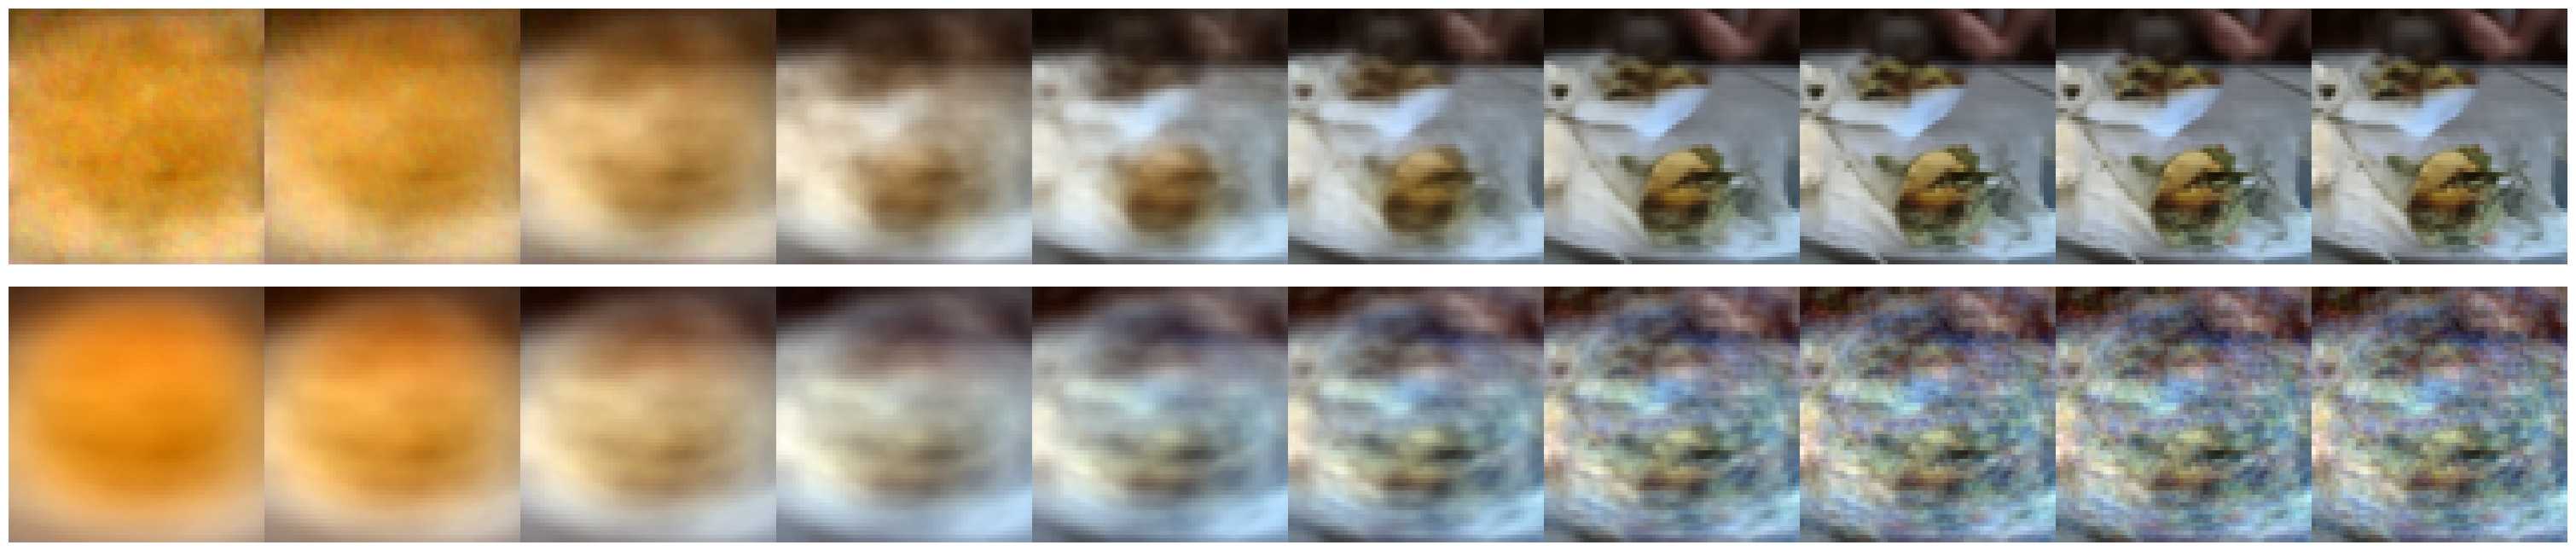

Image 4


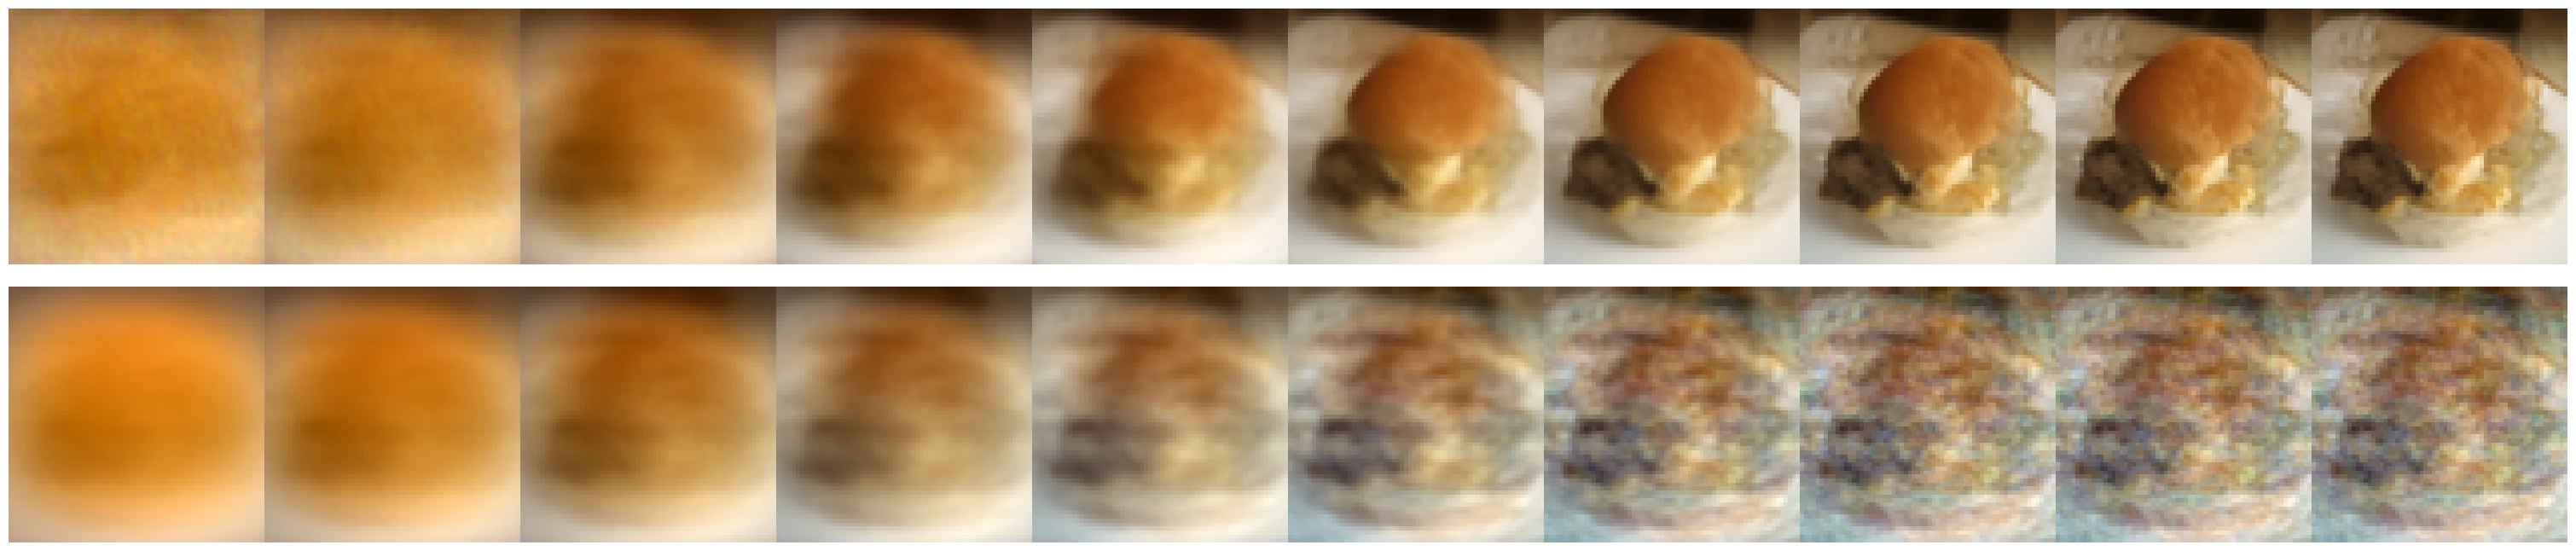

Image 5


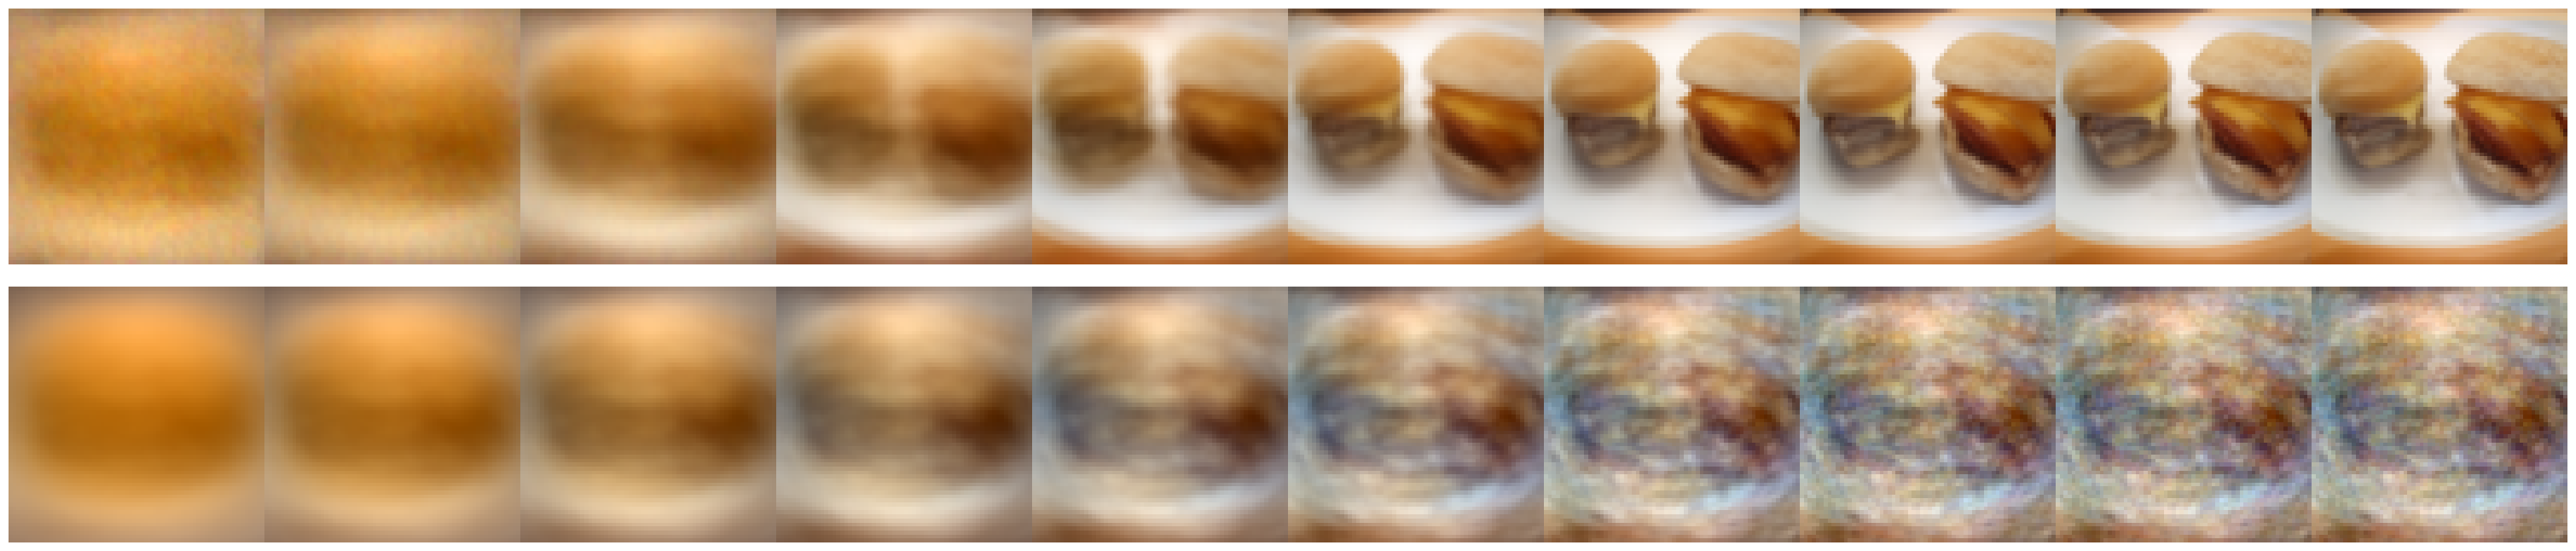

Image 6


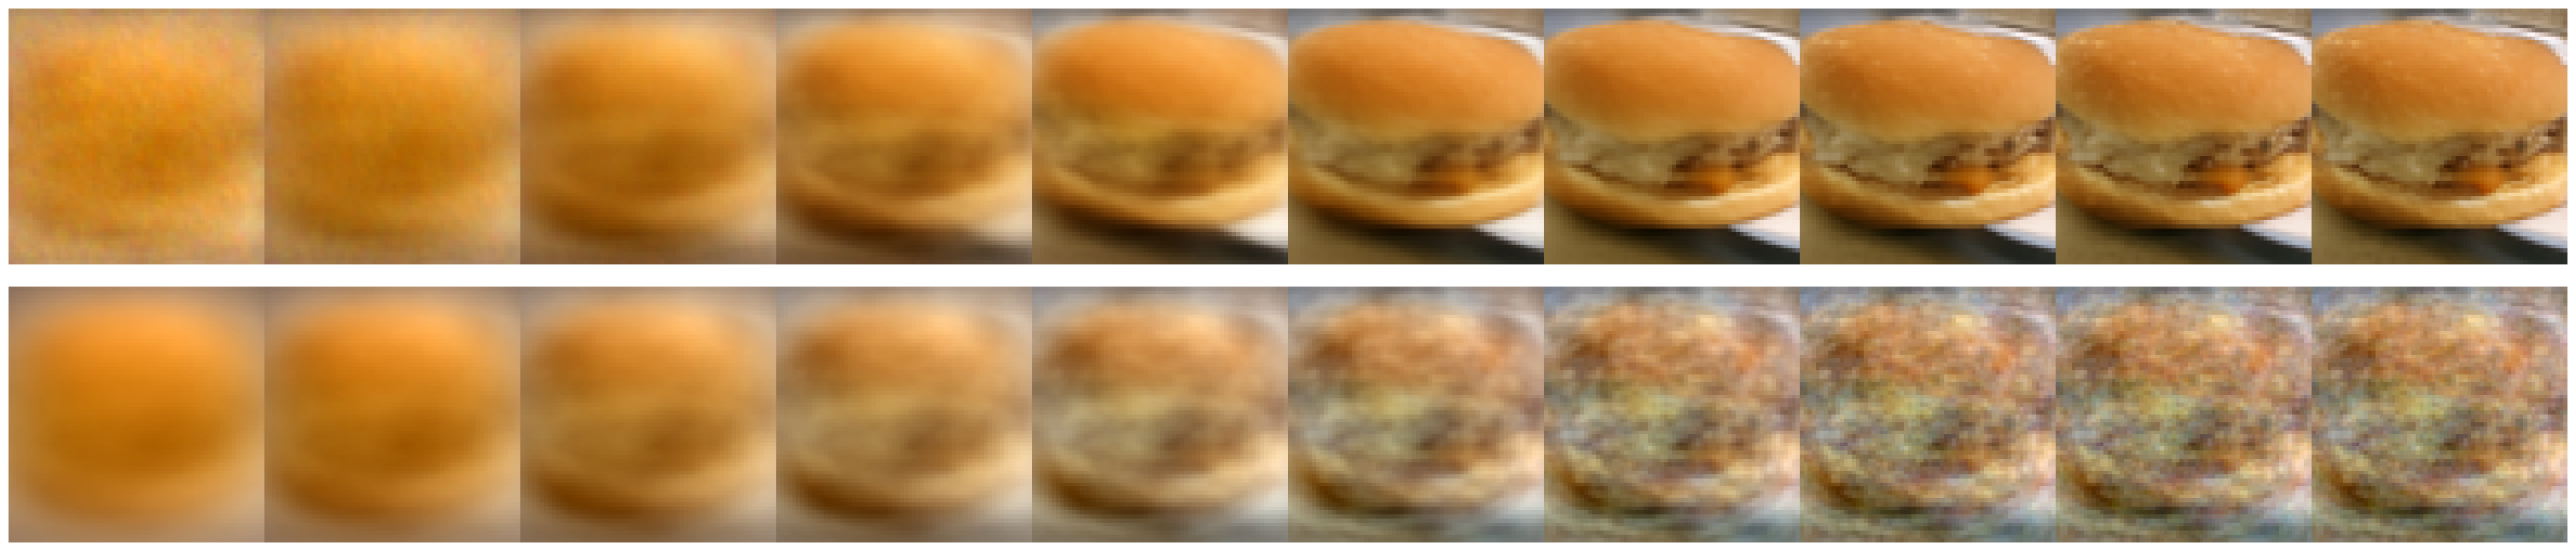

Image 7


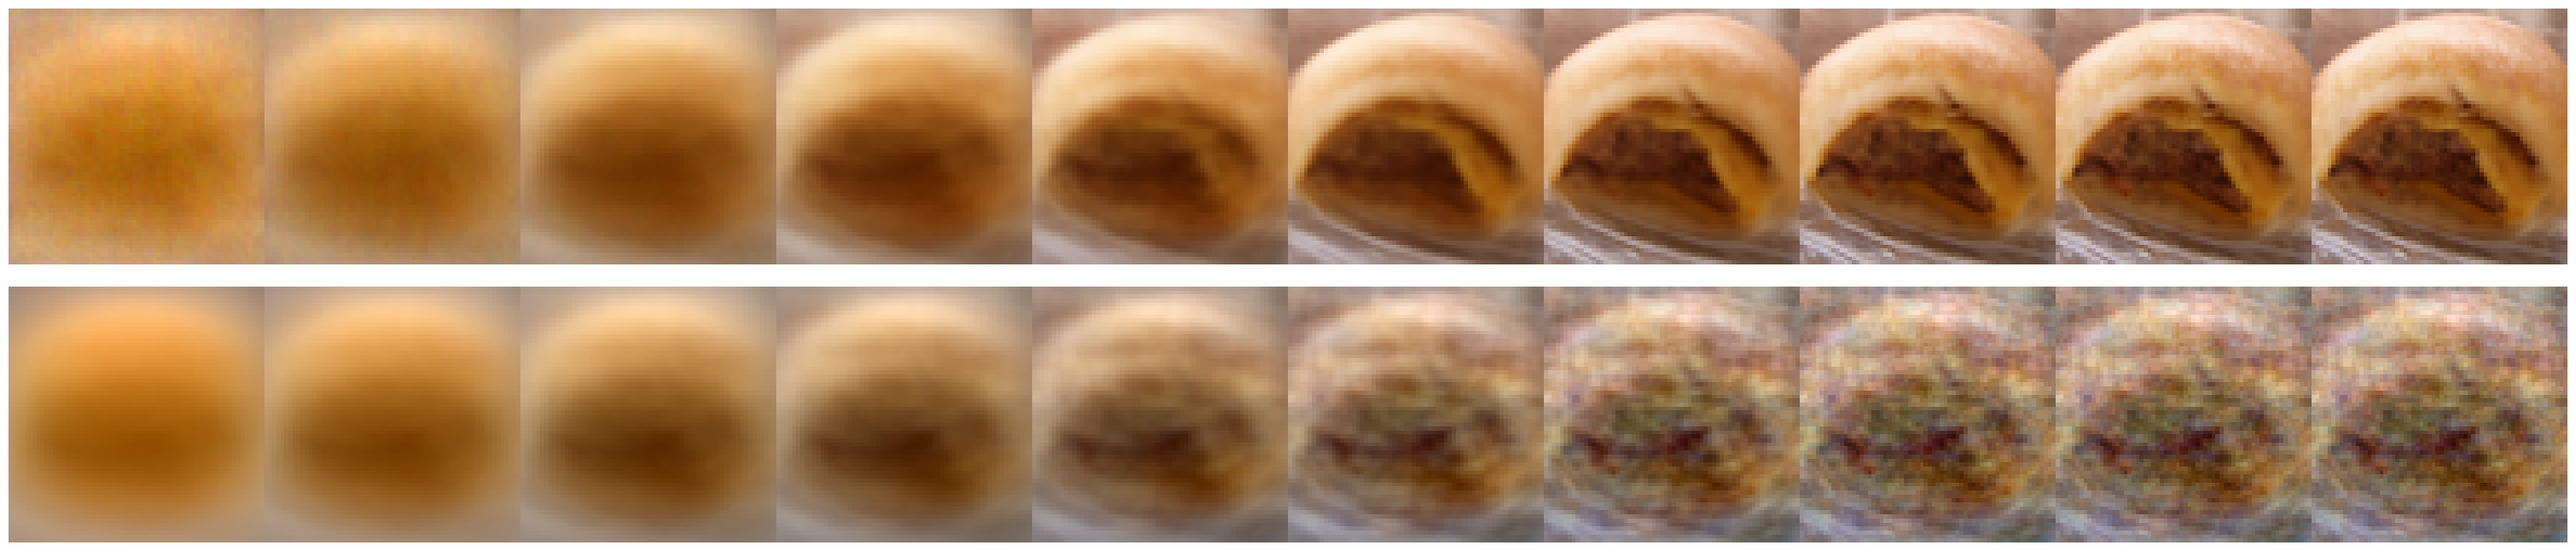

Image 8


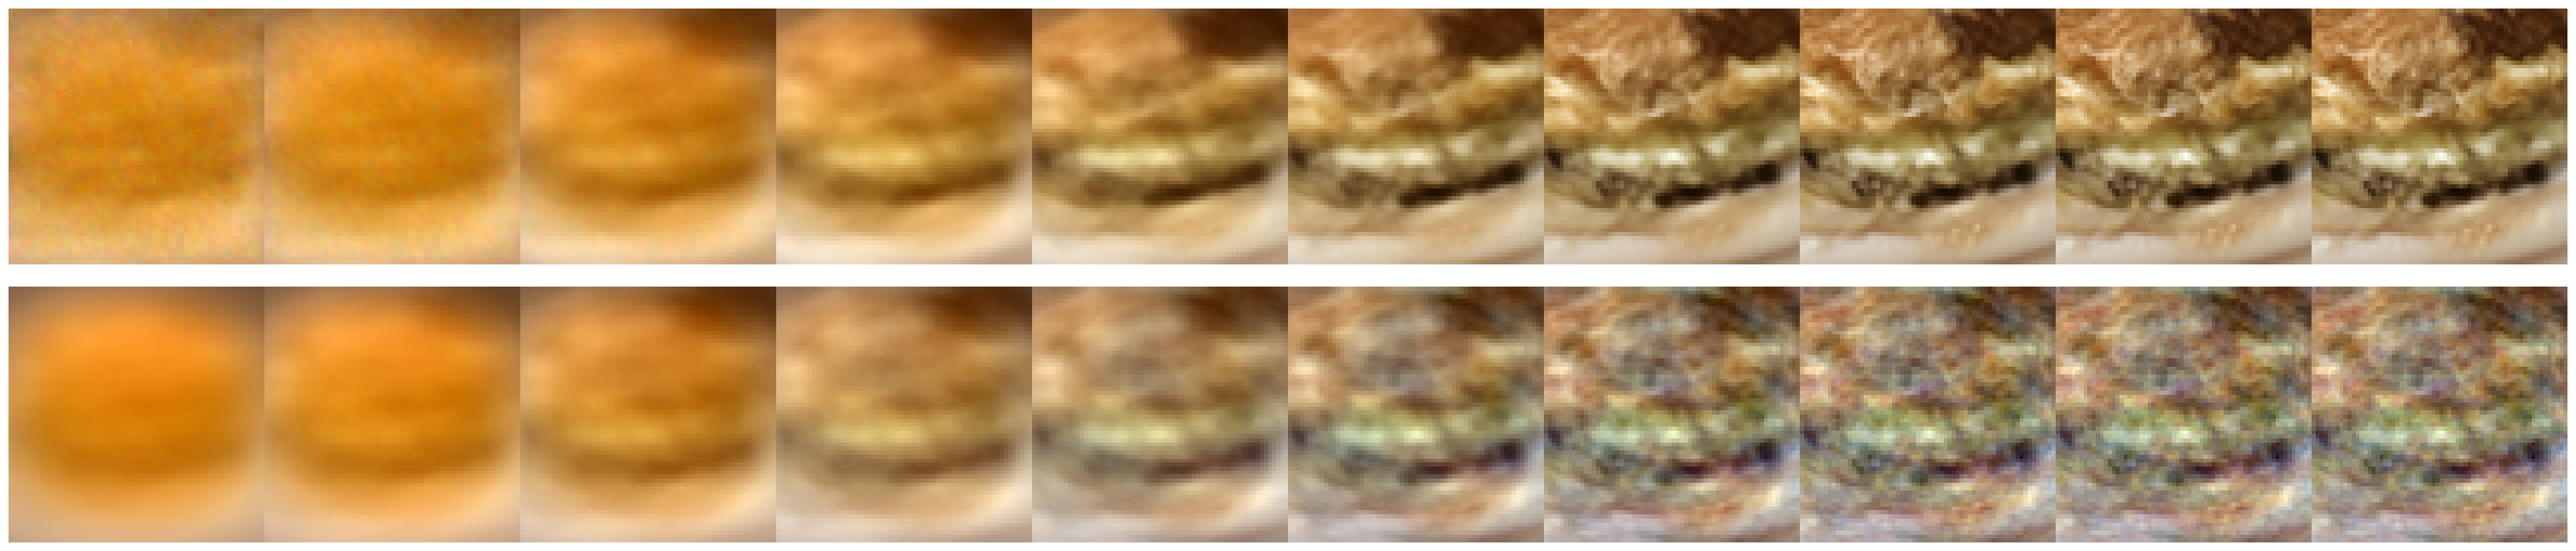

Image 9


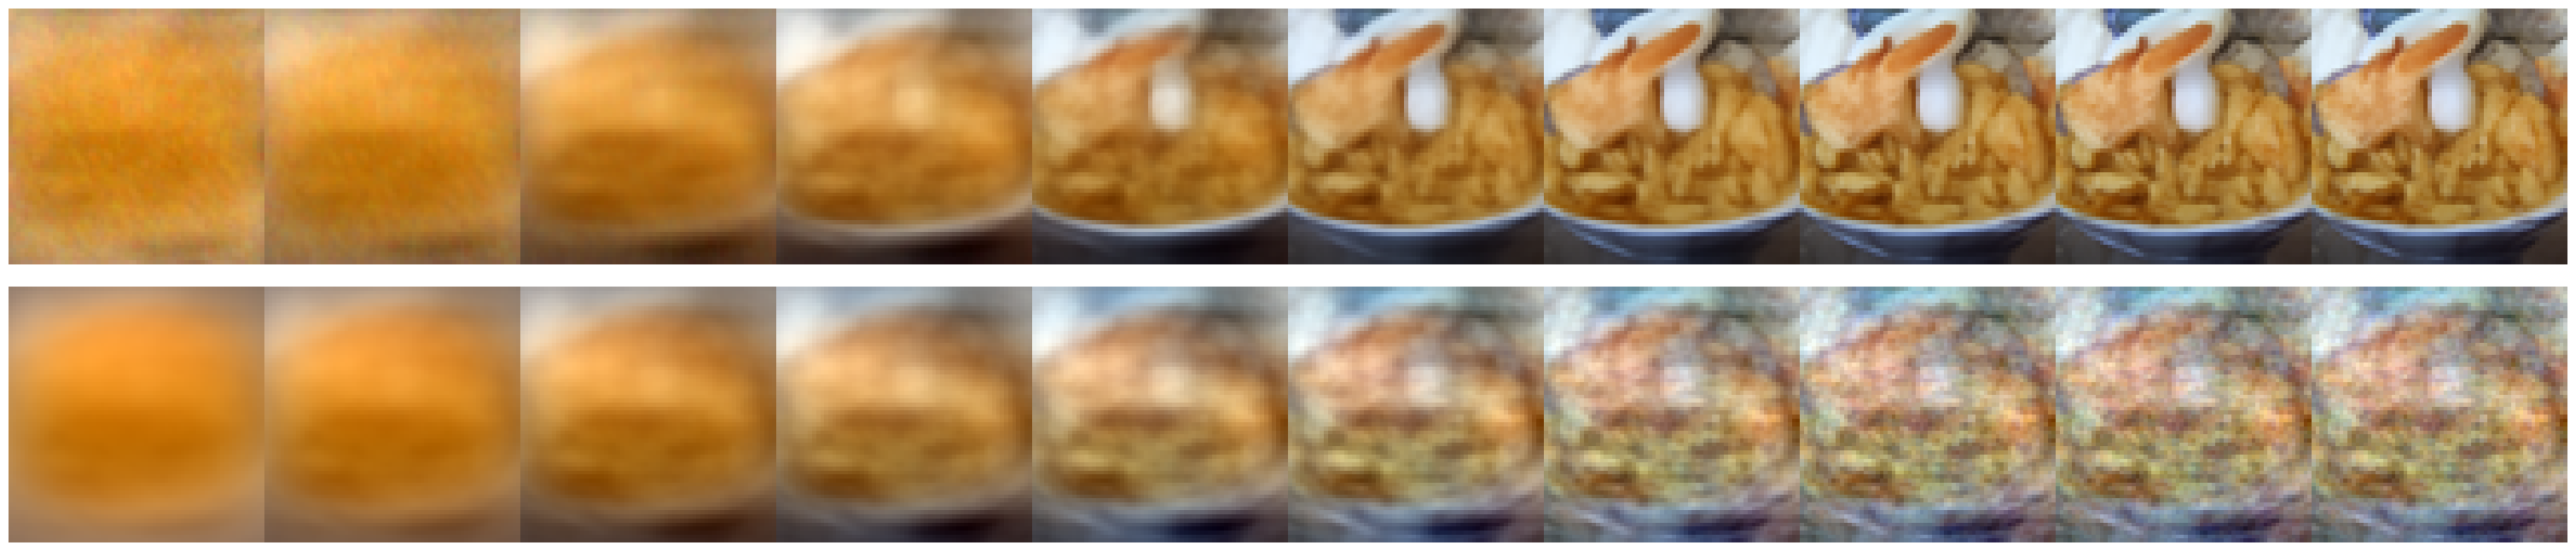

Image 10


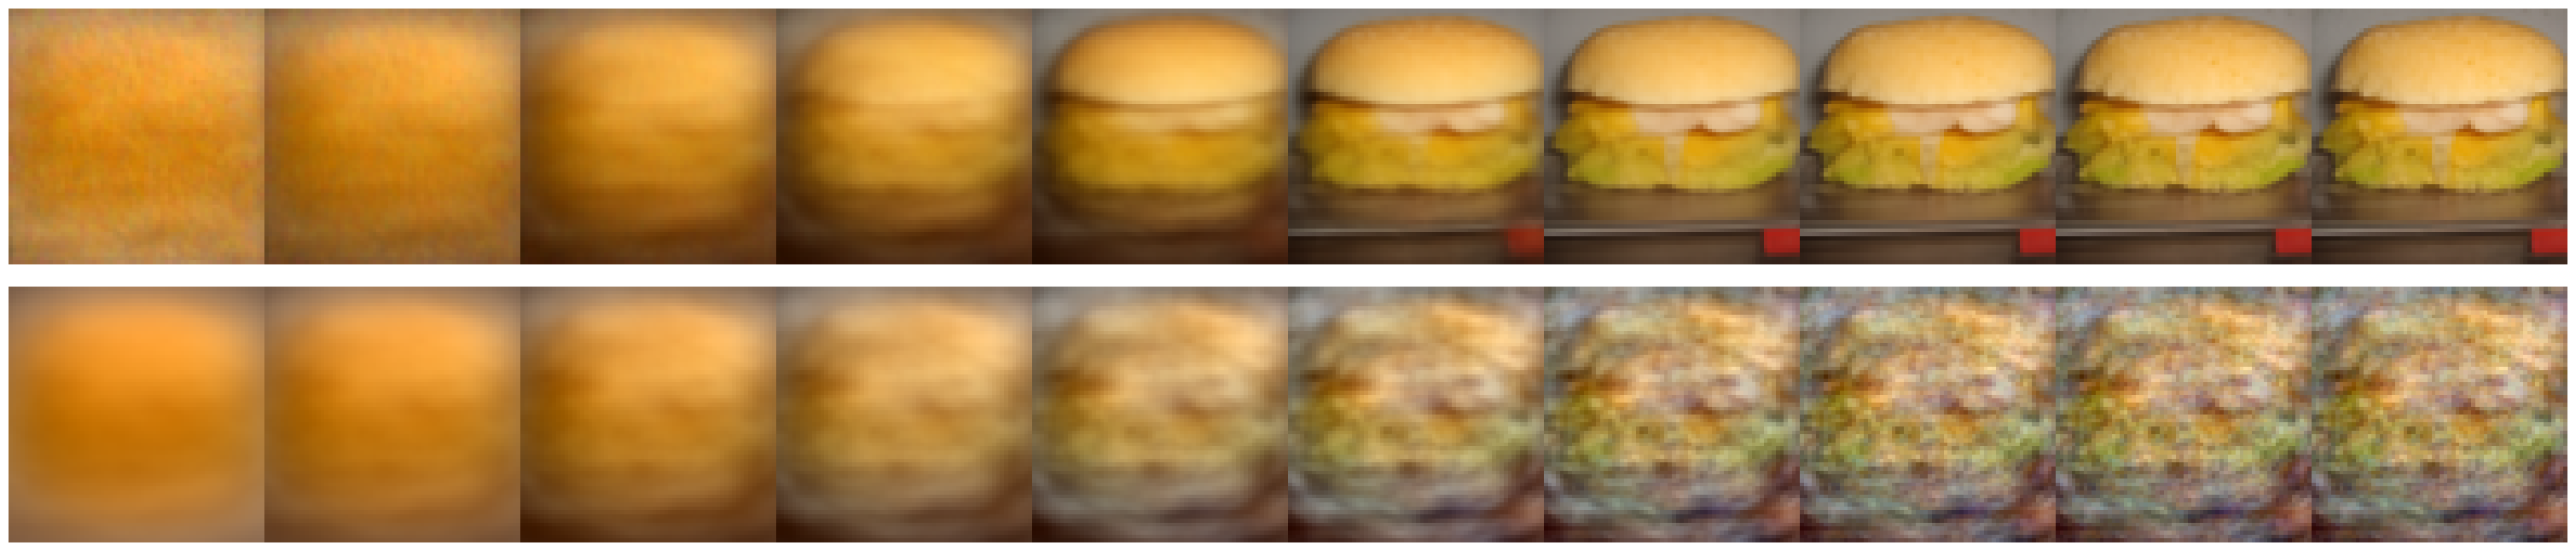

In [12]:
torch.manual_seed(0)
class_idx = 933 # Here we use class 933 (cheeseburger), the linear-to-nonlinear transition holds on other classes as well: [0, 31, 64, 207, 430, 483, 504, 817, 933, 947]

rank = 3*64*64 
mean_path_cond = os.path.join('Covariance_ImageNetGenerated','class_'+str(class_idx),'mean.pt') #'Covariance_ImageNetGenerated/class_933/mean.pt' #'Covariance_Cifar/50000/mean.pt'
covariance_path_cond = os.path.join('Covariance_ImageNetGenerated','class_'+str(class_idx),'covariance.pt') #'Covariance_ImageNetGenerated/class_933/covariance.pt'#'Covariance_ImageNet/dog/my_covariance.pt' #'Covariance_Cifar/50000/covariance.pt'
mean_cond = torch.load(mean_path_cond, weights_only=False)
mean_cond = mean_cond.to(device)
U, S, Vh = torch.load(covariance_path_cond, weights_only=False)
U = U.to(device)
S = S.to(device)
Vh = Vh.to(device)

covariance_cond = U, S, Vh

Gaussian_model_cond = multi_gaussian(mean_cond, covariance_cond, low_rank=rank).to(device)

net_cond_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-imagenet-64x64-cond-adm.pkl'
with dnnlib.util.open_url(net_cond_pkl) as f:
    net_cond = pickle.load(f)['ema'].to(device)
    
num_show = 10
num_steps = 10
num_channels = 3
resolution = 64
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device)

# Generate Image with Gaussian
sigma_list, intermediates_Gaussian, denoised_intermediates_Gaussian = generate_image_Gaussian(net_cond, Gaussian_model_cond, latents ,num_steps=num_steps, device=device)

# Conditional generation with EDM
sigma_list, intermediates_EDM, denoised_intermediates_EDM_cond = generate_image(net_cond, latents, num_steps=num_steps, class_idx=class_idx, device=device)

print('First row: EDM Sampling Trajectory')
print('Second row: Linear Sampling Trajectory')    

for i in range(num_show):
    print('Image', i+1)
    # Create a figure with 2 rows and num_steps columns
    fig, axes = plt.subplots(
        nrows=2, 
        ncols=num_steps, 
        figsize=(num_steps * 3, 8)
    )  # adjust figsize as desired
    
    plt.subplots_adjust(wspace=0.5, hspace=0)

    # --- Row 1: EDM conditional generation trajectory ---
    for j in range(num_steps):
        img = denoised_intermediates_EDM_cond[j][i]  # shape: (C,H,W)
        axes[0, j].imshow(normalize_image(img.permute(1,2,0).detach().cpu()))
        axes[0, j].axis('off')
        
        # Label the row on the leftmost subplot
        if j == 0:
            axes[0, j].set_ylabel('EDM cond', fontsize=12)
            
    # --- Row 2: Gaussian trajectory---
    for j in range(num_steps):
        img = denoised_intermediates_Gaussian[j][i]
        axes[1, j].imshow(normalize_image(img.permute(1,2,0).detach().cpu()))
        axes[1, j].axis('off')
        
        if j == 0:
            axes[1, j].set_ylabel('Gaussian', fontsize=12)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()

### Note that for high to moderate noise levels, linear diffusion models well approximate the actual nonlinear diffusion models. This linearity of actual diffusion models justifies our choice of using linear model as a principled prototype for understanding CFG. In particular, the above results demonstrate that the covariance structures play a significant role in shaping the high-level features of the generated samples. The examples below further demonstrate our argument: conditional linear models generate samples with highly similar structures due to the lack of class-specificity of data covariances, and similar failure modes can be observed in the samples of actual diffusion models. 

In [13]:
torch.manual_seed(0)
class_idx_list = [0, 31, 64, 207, 933, 947]
num_show = 16
num_steps = 10
num_channels = 3
resolution = 64
latents = torch.randn(num_show, num_channels, resolution, resolution).to(device)
edm_naive_conditional_sampling_list = []
linear_naive_conditional_sampling_list = []
for i in range(len(class_idx_list)):
    class_idx = class_idx_list[i]
    # generate images with EDM model
    sigma_list, _, denoised_intermediates_EDM_cond = generate_image(net_cond, latents, num_steps=num_steps, class_idx=class_idx, device=device)
    # store the generate samples
    edm_naive_conditional_sampling_list.append(denoised_intermediates_EDM_cond[-1])

    # build linear model
    mean_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/mean.pt'
    covariance_path_cond = 'Covariance_ImageNetGenerated/class_'+str(class_idx)+'/covariance.pt'
    mean_cond = torch.load(mean_path_cond, weights_only=False)
    mean_cond = mean_cond.to(device)
    U, S, Vh = torch.load(covariance_path_cond, weights_only=False)
    U = U.to(device)
    S = S.to(device)
    Vh = Vh.to(device)
    covariance_cond = U, S, Vh
    Gaussian_model_cond = multi_gaussian(mean_cond, covariance_cond, low_rank=rank).to(device)
    # generate images with linear model
    sigma_list, _, denoised_intermediates_Gaussian_cond = generate_image_Gaussian(net_cond, Gaussian_model_cond, latents, num_steps=num_steps, device=device) # note we pass the EDM model (net_cond) here only for constructing the sampling schedule, the samples are purely generated by the linear model
    # store the generated samples
    linear_naive_conditional_sampling_list.append(denoised_intermediates_Gaussian_cond[-1])

100%|██████████| 10/10 [00:00<00:00, 120.39step/s]


sample index: 0


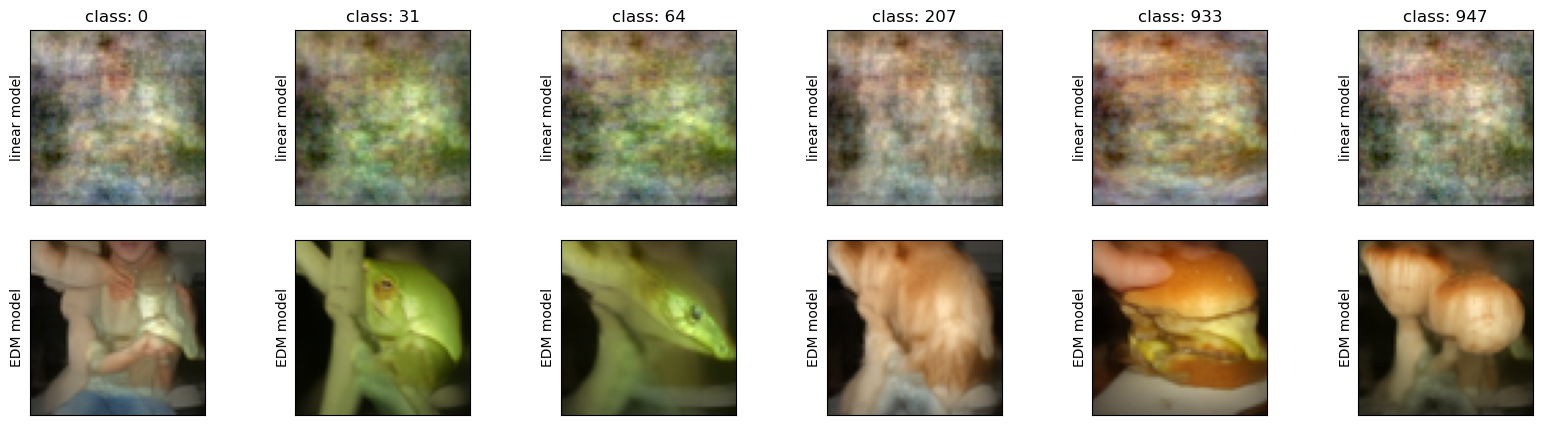

sample index: 2


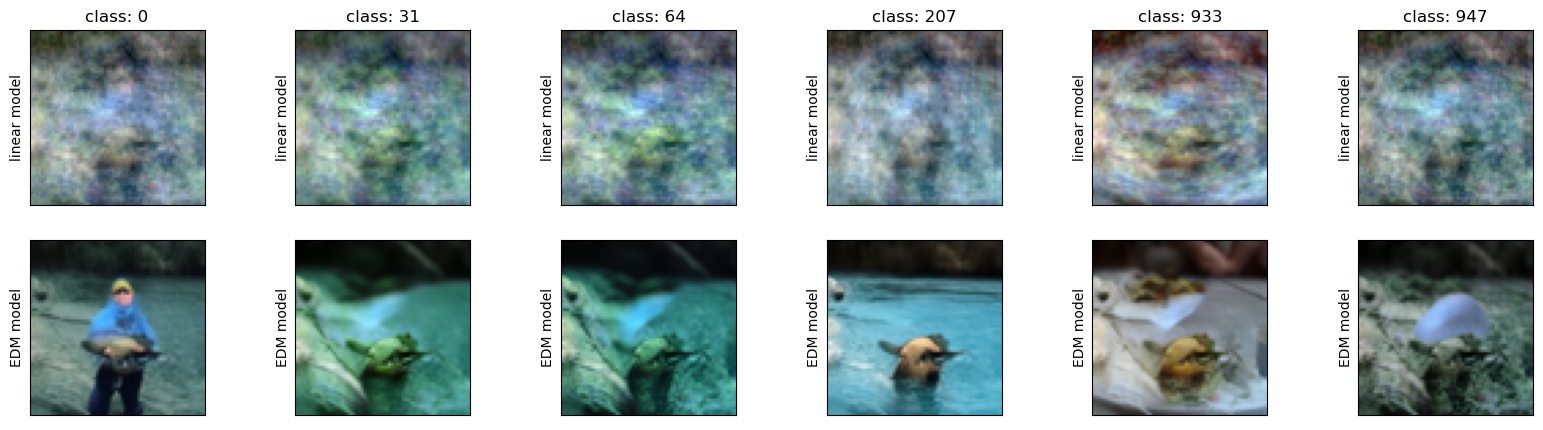

sample index: 3


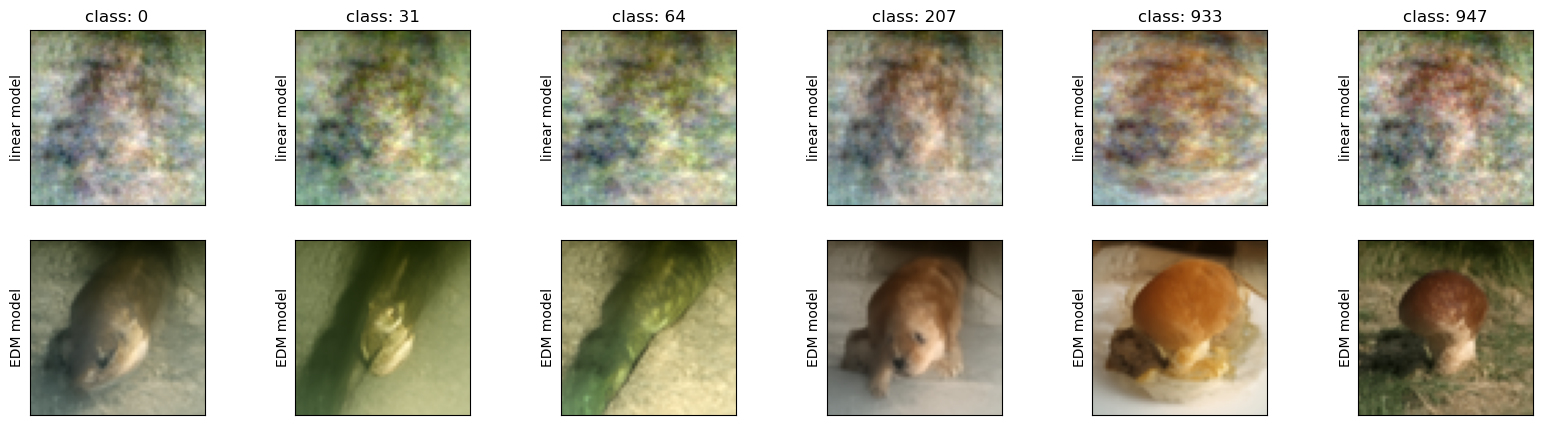

sample index: 5


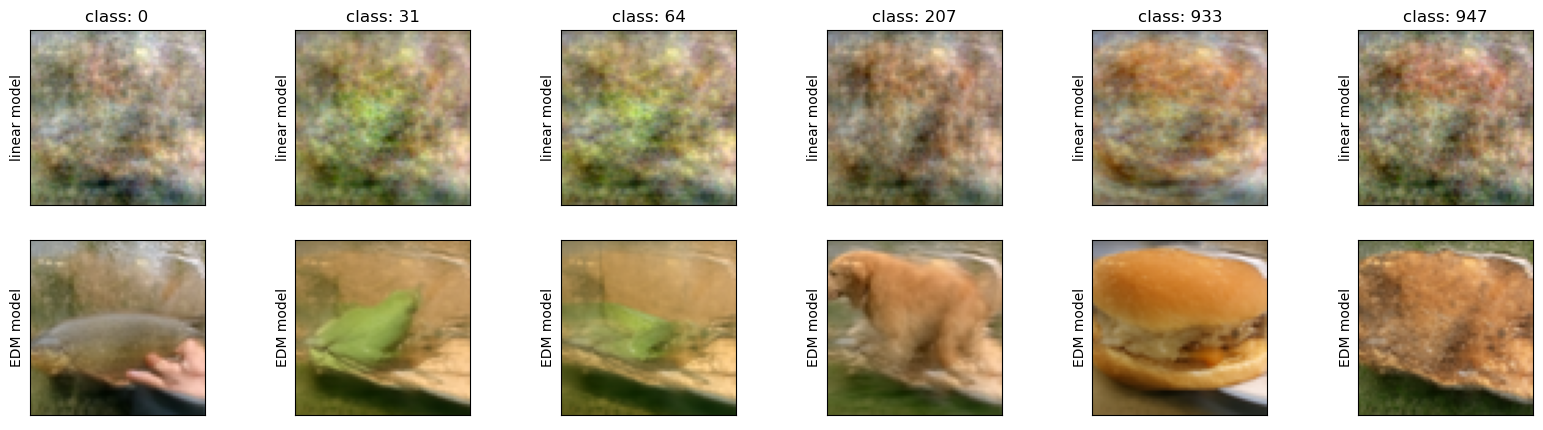

sample index: 7


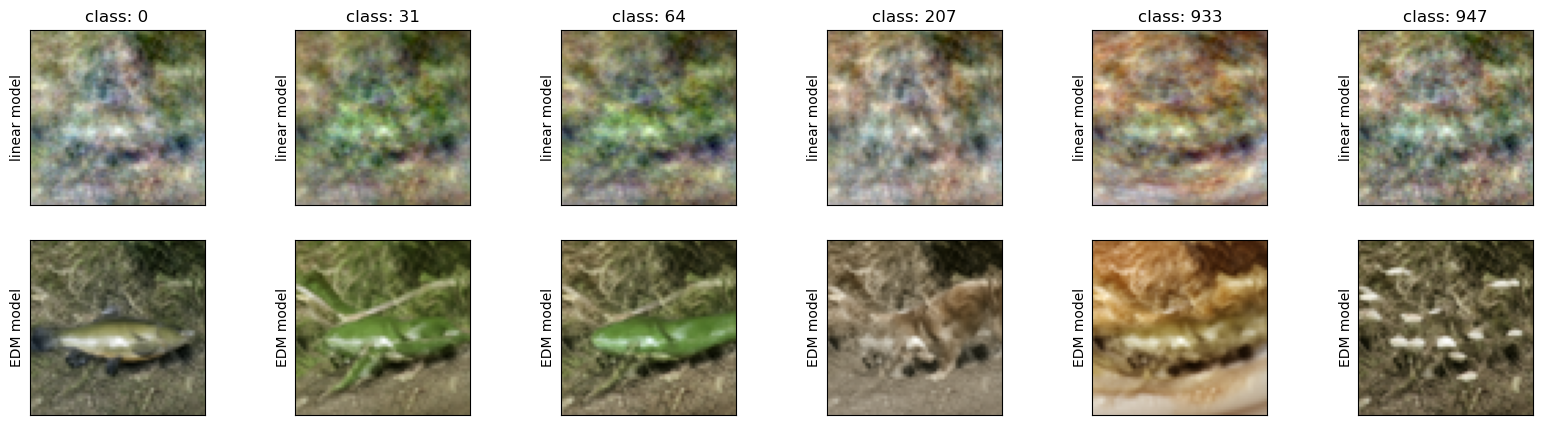

sample index: 8


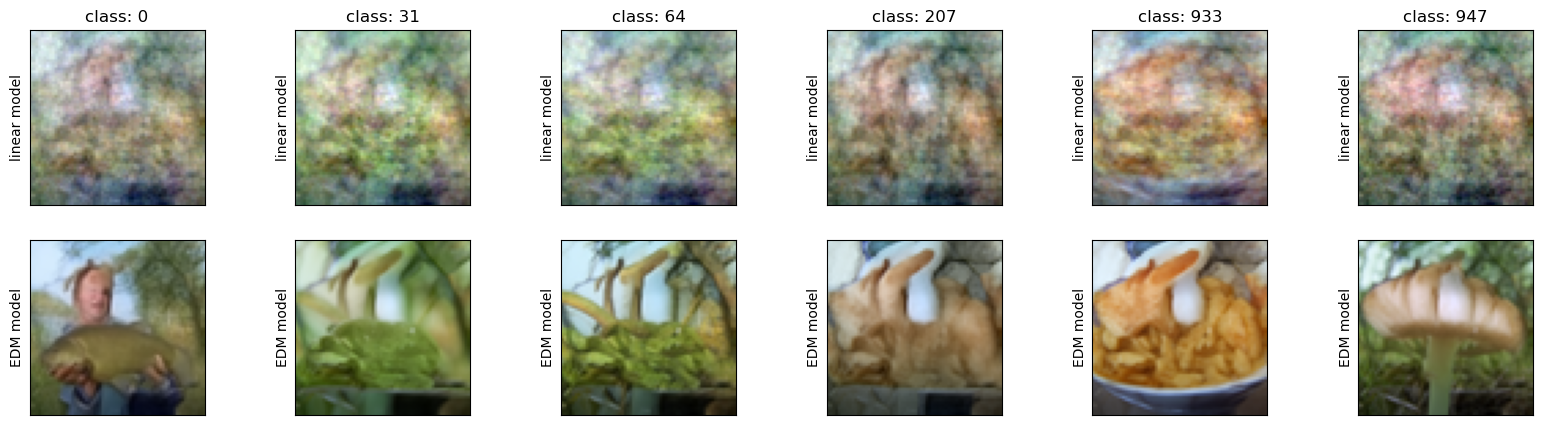

In [28]:
# Visualization
sample_idx_list = [0, 2, 3, 5, 7, 8] # visualize selected samples
for i in range(len(sample_idx_list)):
    sample_idx = sample_idx_list[i]
    print('sample index: '+str(sample_idx))
    plt.figure(figsize=(20,5))
    for j in range(len(class_idx_list)):
        plt.subplot(2,len(class_idx_list),j+1)
        plt.title('class: '+str(class_idx_list[j]))
        plt.imshow(normalize_image(linear_naive_conditional_sampling_list[j][sample_idx].permute(1,2,0)))
        plt.ylabel('linear model')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2,len(class_idx_list),j+1+len(class_idx_list))
        #plt.title('class: '+str(class_idx_list[j]))
        plt.imshow(normalize_image(edm_naive_conditional_sampling_list[j][sample_idx].permute(1,2,0)))
        plt.ylabel('EDM model')
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Lastly, we want to emphasize that there is nothing wrong with learning the data covariance. In fact, we expect a good diffusion model to accurately learn the data covariance, since it is a very important data statistic. The issue here is that covariance, despite being fundamental data statistics, cannot capture the rich, nonlinear dependencies necessary for high quality generation. Diffusion models might rely too much on covariances for generation, while cannot well learn the more important aspects of the training data. This might be due to the famous "simplicity bias", which states that deep networks favor learning low-order, linearly structured representations over complex, higher-order dependencies.